In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_score

from scipy.linalg import pinv2
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin

np.random.seed(0)

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# The following code is used for hiding the warnings and make this notebook clearer.
import warnings
warnings.filterwarnings('ignore')

def executa_teste(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [3]:
class Camada():
    def __init__ (self, qtde_nosEntrada, qtde_nosSaida, taxa_aprendizado = 0.2, debug = True):
        
        self.debug = debug
        
        self.nosEntrada       = qtde_nosEntrada
        self.nosSaida         = qtde_nosSaida
        self.taxa_aprendizado = taxa_aprendizado

        # gera um array com o shape (nos_entrada, nos_saida), multiplica cada valor do array por 2 e depois subtrai 1, para o resultado ficar entre -1 e 1.
        self.pesos = 2 * np.random.rand(self.nosEntrada, self.nosSaida) - 1

    def sigmoide(self, z):
        r = 1.0 / (1.0 + np.exp(-z))
        return r

    def derivada_sigmoide(self, z):
        r = np.multiply(z, (1 - z))
        return r

    def forward (self, entrada):
        
        self.entrada = entrada

        if self.debug: print("\t\tforward self.entrada: {} -- tipo {} -- shape {}".format(self.entrada, type(self.entrada), self.entrada.shape))
        if self.debug: print("\t\tforward self.pesos: {} -- tipo {} -- shape {}".format(self.pesos, type(self.pesos), self.pesos.shape))
            
        r = np.dot(self.entrada, self.pesos)
        self.saida = self.sigmoide(r)
        
        if self.debug: print("\t\tforward self.saida: {} -- tipo {} -- shape {}".format(self.saida, type(self.saida), self.saida.shape))
        
        return self.saida

    def backward(self, d_erro):
        
        if self.debug: print("\t\tbackward derivada_erro: {} -- tipo {} -- shape {}".format(d_erro, type(d_erro), d_erro.shape))
        
        # realiza o calculo da derivada da função de ativação passando a saída da camada como parametro para essa derivada
        d_saida = self.derivada_sigmoide(self.saida)
        if self.debug: print("\t\tbackward derivada_saida: {} -- tipo {} -- shape {}".format(d_saida, type(d_saida), d_saida.shape))

        #faz a multiplicação da derivada de erro com a derivada da saída
        d_erro_saida = np.multiply(d_erro, d_saida)
        if self.debug: print("\t\tbackward derivada_erro_derivada_saida: {} -- tipo {} -- shape {}".format(d_erro_saida, type(d_erro_saida), d_erro_saida.shape))

        #obtem a transposta dos pesos da camada
        transposta_pesos = np.transpose(self.pesos)
        if self.debug: print("\t\tbackward self.pesos: {} -- tipo {} -- shape {}".format(self.pesos, type(self.pesos), self.pesos.shape))
        if self.debug: print("\t\tbackward transposta_pesos: {} -- tipo {} -- shape {}".format(transposta_pesos, type(transposta_pesos), transposta_pesos.shape))

        # faz o dot product da derivada de erro multiplicada pela derivada de saída com a transposta de pesos
        # isso é o que será encaminhado para a camada anterior
        d = np.dot(d_erro_saida, transposta_pesos)
        if self.debug: print("\t\tbackward d: {} -- tipo {} -- shape {}".format(d, type(d), d.shape))

        # faz a alteração nos pesos com base na taxa de aprendizado e na derivada de erro multiplicada pela derivada de saída
        transposta_entrada = self.entrada.reshape(len(self.entrada), 1)
        if self.debug: print("\t\tbackward self.entrada: {} -- tipo {} -- shape {}".format(self.entrada, type(self.entrada), self.entrada.shape))
        if self.debug: print("\t\tbackward transposta entrada: {} -- tipo {} -- shape {}".format(transposta_entrada, type(transposta_entrada), transposta_entrada.shape))

        # foi utilizado o @ notation, mas também daria certo com o np.dot
        #d2 = np.dot(transposta_entrada, derivada_erro_derivada_saida)
        d2 = transposta_entrada @ d_erro_saida.reshape(1, len(d_erro_saida))
        if self.debug: print("\t\tbackward d2: {} -- tipo {} -- shape {}".format(d2, type(d2), d2.shape))

        self.pesos -= self.taxa_aprendizado * d2

        return d

In [4]:
class RedeNeural(BaseEstimator, ClassifierMixin):
    #camadas = [2, 2, 1]
    def __init__ (self, camadas, epocas = 10000, taxa_aprendizado = 0.2, debug = True): 
        
        self.taxa_aprendizado = taxa_aprendizado
        self.epocas           = epocas
        self.debug            = debug
        
        bias_entrada = 1
        bias_saida   = 1
        
        # a quantidade de camadas ocultas é o total de camadas, menos as camadas inicial e final.
        qtde_camadas_ocultas = len(camadas) - 2
        
        # Cria a primeira camada da rede neural - inclui o nó bias na camada de entrada e na primeira camada oculta
        self.camadas = np.array([Camada(camadas[0] + bias_entrada, camadas[1] + bias_saida, self.taxa_aprendizado, self.debug)])

        # Cria as camadas ocultas - inclui o nó bias na camada de entrada e na primeira camada oculta da iteração
        for i in range(qtde_camadas_ocultas - 1):
            self.camadas = np.append(self.camadas, [Camada(camadas[i+1] + bias_entrada, camadas[i+2] + bias_saida, self.taxa_aprendizado, self.debug)])

        # Cria a camada de saída - inclui o nó bias na camada de entrada e não inclui na camada de saída
        self.camadas = np.append(self.camadas, [Camada(camadas[-2] + bias_entrada, camadas[-1], self.taxa_aprendizado, self.debug)])
        
    def print_arquitetura(self):
        print("qtde_camadas_ocultas: {}".format(len(self.camadas) - 1))
        for camada in self.camadas:
            print("camada")
            print("\tnúmero de nós de entrada: {}".format(camada.nosEntrada))
            print("\tnúmero de nós de saída:   {}".format(camada.nosSaida))
            print("\tpesos da camada:          {} -- tipo {} -- shape {}".format(camada.pesos, type(camada.pesos), camada.pesos.shape))
            print()
            
    #dispara o sinal da primeira camada para a última
    def avalia_registro(self, entrada):
        #adiciona o bias na entrada
        entrada = np.concatenate((np.ones(1).T, np.array(entrada)))

        if self.debug: print("\tinicio avalia_registro: {}".format(entrada))

        for camada in self.camadas:
            entrada = camada.forward(entrada)
            
            if self.debug: print("\tintermediario avalia_registro, resultado camada.forward: {}".format(entrada))

        return entrada

    def avalia_erro(self, valor_esperado, saida_camada):
        r = np.multiply(0.5, np.multiply((valor_esperado - saida_camada), (valor_esperado - saida_camada)))
        return r

    def calcula_delta_erro(self, valor_esperado, saida_camada):
        r = saida_camada - valor_esperado
        return r

    def fit(self, X, y):
        if self.debug: print("X shape: {}".format(X.shape))

        for i in range(self.epocas):
            for j in range(X.shape[0]):
                
                # Para cada registro do vetor de entrada, obtemos o resultado do forward
                entrada = X[j]
                
                if self.debug: print("X da vez: {}".format(entrada))
                
                saida = self.avalia_registro(entrada)
                
                if self.debug: print("\tsaida do X da vez: {}".format(saida))
                
                esperado = y[j]
                
                if self.debug: print("\ty da vez: {}".format(esperado))
                
                vetor_erro = self.avalia_erro(esperado, saida)

                if self.debug: print("\terro da vez: {}".format(vetor_erro))

                # calcula a derivada do erro
                delta_erro = self.calcula_delta_erro(esperado, saida)
                
                if self.debug: print("delta do erro da vez: {}".format(delta_erro))
                
                for l in range(len(self.camadas) -1, -1, -1):
                    delta_erro = self.camadas[l].backward(delta_erro)
                    
    def predict(self, X):
        resultado = []
        
        if self.debug: print("X: {}".format(X))

        for x in X:
            if self.debug: print("x: {}".format(x))

            r = self.avalia_registro(x)
            
            if self.debug: print("r: {}".format(r))
            
            resultado.append(r)
            
            if self.debug: print()
        
        return np.array(resultado)

In [5]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

In [6]:
#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 2, 1], debug = False)
rna.fit(X, y)
resultado = rna.predict(X)
resultado

array([[0.03771873],
       [0.94551077],
       [0.95027847],
       [0.07847588]])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


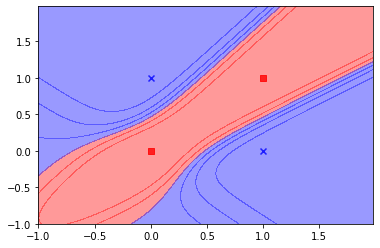

In [7]:
#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 2, 1], debug = False)
rna.fit(X, y)
executa_teste(X, y, rna)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


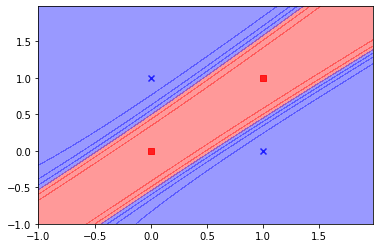

In [8]:
#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 3, 1], debug = False)
rna.fit(X, y)
executa_teste(X, y, rna)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


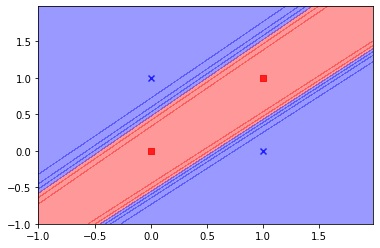

In [9]:
#atentar-se ao fato de que é inserido um nó bias em cada camada, exceto a última
rna = RedeNeural([2, 4, 3, 1], debug = False)
rna.fit(X, y)
executa_teste(X, y, rna)

# Resultados

Nesta tarefa foi pedido que fosse implementada uma rede neural do tipo feed forward, porém, ao contrário da tarefa 5, nessa atividade foi solicitado o mecanismo de backward que é a etapa de ajuste dos pesos. Dessa maneira, implementamos uma rede neural contendo um único parametro não default que é o vetor de entrada que simboliza a arquitetura da rede neural, assim, um vetor \[2, 2, 1\]  significa que o programa construirá uma rede neural de 3 camadas, sendo uma oculta, e que na primeira e segunda camada existem dois neurônios, mais um neurônio de bias em cada camada, e na última camada, existe apenas um neurônio.

Foram implementados os métodos forward e backward. No forward é onde ocorre a multiplicação do vetor de pesos da camada pela entrada contendo o bias e esse resultado passa pela função sigmóide, para normalizar o resultado. Na fase backward, é recebido um valor de erro resultado da forward e o valor esperado, e com esse valor de erro, os pesos são recalculados.

Ao contrário da atividade 5, nesta atividade foi possível implementar um método fit que faça sentido, realizando o treinamento da rede neural. Caso deseje ver os valores, basta ativar o modo debug, setando o parametro para True. Mas cuidado, o numero de epocas está em 10.000 como padrão, o que pode causar travamentos do navegador ou lentidão, pois o debug é bastante verboso.

Podemos ver também que arquiteturas diferentes geram resultados diferentes.